# Recommendations with IBM

In this notebook, I put my recommendation skills to use on real data from the IBM Watson Studio platform. 


Here is the rubric it was evaluated against as part of Udacity's Data Science nano degree program: [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view). 

In this notebook I build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Matrix Factorization](#Matrix-Fact)<br>
V. [Extras & Concluding](#conclusions)

I start by importing the necessary libraries and reading in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

In [2]:
#Get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [3]:
# Show df_content
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

I use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

In [4]:
#get the categories of analysis
print(df.columns)
print(df_content.columns)

Index(['article_id', 'title', 'email'], dtype='object')
Index(['doc_body', 'doc_description', 'doc_full_name', 'doc_status',
       'article_id'],
      dtype='object')


So the main data set is the `df`. It contains a record of every interaction between a user and an article. I don't see any uses for the `df_content` file but I'll keep an open mind. 

In [5]:
#save key descriptives in variable
interactions  = df.shape[0]
unique_articles = df.article_id.unique().shape[0]
unique_users = df.email.unique().shape[0]

#report in prose
print(f"The data set records {interactions} interactions between {unique_users} users \
and {unique_articles} articles in the record.")
      

The data set records 45993 interactions between 5149 users and 714 articles in the record.


In [6]:
df.isnull().sum()

article_id     0
title          0
email         17
dtype: int64

Some of the users don't have an email. There are only 17 so I think it is safe to drop them. 

In [7]:
print(df.shape)
print(df.dropna(subset=['email']).shape)

(45993, 3)
(45976, 3)


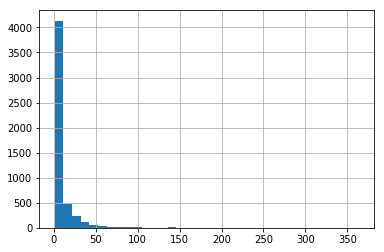

In [8]:
df.groupby('email')['article_id'].count().hist(bins=35)

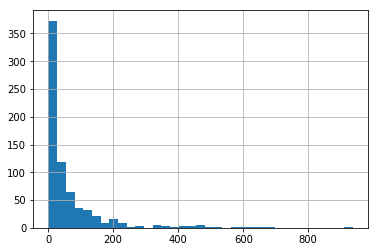

In [9]:
df.groupby('article_id')['email'].count().hist(bins=35)

In [10]:
#save key statistics in variables
mean_articles = np.round(df.groupby('email')['article_id'].count().mean(), 2)
stdev_articles = np.round(df.groupby('email')['article_id'].count().std(),2)
median_articles = int(df.groupby('email')['article_id'].count().median())
modal_articles = df.groupby('email')['article_id'].count().mode()[0]

#report in english
print(f'The mean number of articles interacted with by a user is { mean_articles } with a standard \
deviation of {stdev_articles}.\nThe median numbers of articles interacted with is {median_articles} \
and the modal value is {modal_articles}.')

The mean number of articles interacted with by a user is 8.93 with a standard deviation of 16.8.
The median numbers of articles interacted with is 3 and the modal value is 1.


In [11]:
#Convert the article id into a string
df['article_id'] = df.article_id.apply(str)

In [12]:
df.article_id.dtype

dtype('O')

In [13]:
# Fill in the median and maximum number of user_article interactions below
median_val = int(df.groupby('email')['article_id'].count().median())
print(f'50% of individuals interact with {median_val} articles or fewer.')
max_views_by_user = df.groupby('email')['article_id'].count().max()
print(f'The maximum number of user-article interactions by any 1 user is {max_views_by_user}.')

50% of individuals interact with 3 articles or fewer.
The maximum number of user-article interactions by any 1 user is 364.


`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [14]:
# Find and explore duplicate articles
print(df_content.shape)
df_content_dd = df_content.drop_duplicates(subset='article_id')
print(df_content_dd.shape)
print(df_content.shape)

(1056, 5)
(1051, 5)
(1056, 5)


In [15]:
df_content[df_content.article_id.duplicated()]['article_id'].head(20)

365     50
692    221
761    398
970    577
971    232
Name: article_id, dtype: int64

In [16]:
df_content.loc[df_content.article_id.duplicated(keep='first'), :]

,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [17]:
# Remove any rows that have the same article_id - only keep the first
df_content.drop_duplicates(subset='article_id', keep='first', inplace=True)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [18]:
# The number of unique articles that have at least one interaction
print(df.article_id.nunique())
print(len(df.groupby('article_id')['email'].count()>0))

714
714


In [19]:
# The number of unique articles on the IBM platform
df.article_id.nunique()

714

In [20]:
# The number of unique articles that have at least one interaction
unique_articles = int(len(df.groupby('article_id')['email'].count()>0))
total_articles = int(df_content.article_id.count())
print(total_articles)
print(unique_articles)

1051
714


In [21]:
# The number of unique users
unique_users_drop_duplicates = int(df.email.drop_duplicates().count())
print(f'There are {unique_users_drop_duplicates} unique users in the data set after we drop the duplicates.')
unique_users = unique_users_drop_duplicates

There are 5148 unique users in the data set after we drop the duplicates.


In [22]:
# The number of user-article interactions
print(df.shape[0])
user_article_interactions = int(df.shape[0])

45993


`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was found that all of these null values likely belonged to a single user (which is how they are stored using the function below).

In [23]:
# The most viewed article in the dataset as a string with one value following the decimal
max_interactions = int(df.groupby('article_id')['email'].count().max())

In [24]:
for ind, val in zip(df.groupby('article_id')['email'].count().index, df.groupby('article_id')['email'].count().values):
    if val == max_interactions:
        most_viewed_article_id = str(ind)

In [25]:
df[df.article_id == 1429.0]['title'].shape

(0,)

In [26]:
# The most viewed article in the dataset was viewed how many times?
max_views = max_interactions

In [27]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [28]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [29]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df.groupby('title')['user_id'].count().sort_values(ascending=False)[:n].index)
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = list(df.groupby('article_id')['user_id'].count().sort_values(ascending=False)[:n].index)
 
    return top_articles # Return the top article ids

In [30]:
print(get_top_articles(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']


In [31]:
print(get_top_article_ids(10))

['1429.0', '1330.0', '1431.0', '1427.0', '1364.0', '1314.0', '1293.0', '1170.0', '1162.0', '1304.0']


In [32]:
import project_tests as t
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [33]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    df['exists'] = int(1)
    user_item = df.groupby(['user_id', 'article_id'])['exists'].apply(max).unstack().fillna(int(0))
    
    return user_item #return the user_item matrix 

In [34]:
user_item = create_user_item_matrix(df)

In [35]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [36]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first.
                    In case of a user not in the data set it returns the existing users'
                    user_ids in existing order.
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered list
    
    '''
    #check to see if there are similar users
    try:
        #get the_user from the user_item matrix, all the columns
        the_user = user_item[user_item.index==user_id][:]
        
        #initialize the list of similar users
        similarities = []
        
        #iterate through rows of user_item matrix 
        for index, row in user_item.iterrows():
            
            #store index and dot product in a tuple
            a = (index, list(the_user.values @ np.array(np.transpose(row))).pop())
            
            #append to list of similar users
            similarities.append(a)
        
        #sort list by second value in tuple (the dot product)
        sorted_by_second = sorted(similarities, key=lambda tup: tup[1], reverse=True)
        
        #create list of user_ids' from sorted tuples
        most_similar_users = [i[0] for i in sorted_by_second]
    
    #if the user is not in our data set
    except:
        #return a list of the first 10 users
        most_similar_users = list(user_item.index.values)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [37]:
def find_similar_users_dot(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list of tuples where the closest users (largest dot product users)
                    are listed first.
                    In case of a user not in the data set it returns the existing users'
                    user_ids in existing order and zeros for the dot product.
    
    Description:
    Returns a list of tuples with the user ids and the dot product
    similarities to the specified user sorted by the dot product. It is
    really just the pervious function with the last step--removing the 
    dot product from the tuples--removed.
    '''
    #check to see if there are similar users
    try:
        
        #get the_user from the user_item matrix, all the columns
        the_user = user_item[user_item.index==user_id][:]
        
        #initialize the list of similar users
        similarities = []
        
        #iterate through rows of user_item matrix 
        for index, row in user_item.iterrows():
            
            #store index and dot product in a tuple
            a = (index, list(the_user.values @ np.array(np.transpose(row))).pop())
            
            #append to list of similar users
            similarities.append(a)
        
        #sort list by second value in tuple (the dot product)
        most_similar_users_dot = sorted(similarities, key=lambda tup: tup[1], reverse=True)
    
    #if the user is not in our data set
    except:
        
        #return a list of the first 10 users
        most_similar_users_dot = list(zip(user_item.index.values, [0 for i in range(len(user_item.index))]))
    
    return most_similar_users_dot

In [38]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [1, 3933, 23, 3782, 203, 4459, 131, 3870, 46, 4201]
The 5 most similar users to user 3933 are: [1, 3933, 23, 3782, 203]
The 3 most similar users to user 46 are: [46, 4201, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [39]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    
    article_names = [list(set(df[df.article_id==i]['title']))[0] for i in article_ids]
    
    return article_names  # Return the article names associated with list of article ids

In [40]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    
    #if  the user is in the data set
    try:
        #get the articles the user has interacted with
        articles_interacted_with = user_item[user_item.index==user_id].values
        
        #convert article ids to int
        articles_interacted_with_int = [int(i) for i in articles_interacted_with[0]]
        
        #initialize list
        articles_list = []
        
        #loop through articles interacted with
        for i, j in enumerate(articles_interacted_with_int):
            
            #if user has interacted with article
            if j==1:
                
                #append article index number to list of articles interacted with
                articles_list.append(i)
        
        #take columns of user_item matrix and save them as article ids
        article_ids = user_item.columns[articles_list]
        
        #call function to use article ids to get article names
        article_names = get_article_names(article_ids, df=df)
    
    #if the users is not in the data set
    except:
        
        #return empty lists
        article_ids = []
        article_names = []
        
    return article_ids, article_names # return the ids and names

In [41]:
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures',\
                                             'self-service data preparation with ibm data refinery',\
                                             'use the cloudant-spark connector in python notebook'])

In [42]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    #call functions to get similar users and the articles the user has seen with titles
    similar_users = find_similar_users(user_id, user_item=user_item)
    seen_articles, seen_articles_titles = get_user_articles(user_id, user_item=user_item)
    
    #initialize recs list
    recs = []
    
    #loop through list of similar users
    for i in similar_users:
        
        #get the articles that user has seen
        articles = get_user_articles(i, user_item=user_item)

        #loop through the article ids
        for article in articles[0]:
            
            #if the user hasn't seen the article
            if article not in seen_articles:
                
                #append it to the list of recommendations
                recs.append(article)  
                
                #break look if length of recs is greater than m
                if len(recs) > m:
                    break
        
        #break the loop if length of recs is greater than 10
        if len(recs) >= m:
            break
    
    
    return recs[:m] # return your recommendations for this user_id    

In [43]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service','gosales transactions for naive bayes model','healthcare python streaming application demo','use r dataframes & ibm watson natural language understanding','use xgboost, scikit-learn & ibm watson machine learning apis']),"Oops! Your the get_article_names function doesn't work quite how we expect."

In [44]:
assert set(get_article_names(['1320.0', '232.0', '844.0'])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."

In [45]:
assert set(get_user_articles(20)[0]) == set(['1320.0', '232.0', '844.0'])

In [46]:
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])


In [47]:
assert set(get_user_articles(2)[0]) == set(['1024.0', '1176.0', '1305.0', '1314.0', '1422.0', '1427.0'])

In [48]:
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])


In [49]:
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [50]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
        
    similarities = find_similar_users_dot(user_id, user_item=user_item)
      
    #change the similarities into a DataFrame
    df_similarities = pd.DataFrame(columns=['user_id', 'similarities'], data=similarities)
    
    #merge that DataFrame with the original df
    df_similarities_merged = pd.merge(df, df_similarities, on='user_id', how='inner')
    
    #create a groupby object to obtain the number of articles each user has 
    #interacted with
    similarities_count = df_similarities_merged.groupby(['user_id'])['exists'].count()
    
    #transform the groupby object into a DataFrame
    similarities_count_df = pd.DataFrame({'user_id':similarities_count.index, 'count': similarities_count.values})
    
    #merge with df_similarities_merged to get user_id, similarities, and count in the same frame
    df_big = pd.merge(df_similarities_merged, similarities_count_df, on='user_id', how='outer')
    
    #groupby user_id and sort by similarity (ascending) and count (descending)
    df_big_sorted = df_big.groupby('user_id')['similarities','count'].max().sort_values(by=['similarities', 'count'], ascending=[False, False])
    
    #add neighbors_id variable
    df_big_sorted['neighbor_id'] = df_big_sorted.index
    
    #give DataFrame the proper column names
    df_big_sorted.columns = ['similarity','num_interactions','neighbor_id']
    
    #drop the reference user
    try:
        neighbors_df = df_big_sorted.drop(user_id)
    except:
        neighbors_df = df_big_sorted
    
    
    
    return neighbors_df # Return the dataframe specified in the doc_string

In [51]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    #get similar users
    similar_users = find_similar_users(user_id, user_item=user_item)
    
    #get articles that the target person has seen
    seen_articles, seen_articles_titles = get_user_articles(user_id, user_item=user_item)
    
    #turn those articles into a set
    reference_articles = set(seen_articles)
    
    #initialize a list for recommendations
    recs = []
    
    #loop through the list of similar users
    for i in similar_users:
        
        #get the articles that user has seen
        compare_articles = set(df[df.user_id == i]['article_id'].values)
        
        #compare with reference set
        difference = compare_articles.difference(reference_articles)
        
        #extend list
        recs.extend(difference)
    
    return recs[:m] # return your recommendations for this user_id    

In [52]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    #initialize lists
    recs = []
    rec_names = []
    
    #get a series of titles by article_ids for use later 
    #returns a series
    series_title = df.groupby('article_id')['title'].max()
    
    #find similar users
    #returns a DataFrame
    similar_users = get_top_sorted_users(user_id, df=df, user_item=user_item)
    
    #get DataFrame of articles sorted by those with the most interactions first
    articles_sorted_by_interactions = pd.DataFrame(df.groupby('article_id')['exists'].count().sort_values(ascending=False))
    
    if similar_users.similarity.sum() == 0:
        recs = list(articles_sorted_by_interactions.index)
        
        for i in articles_sorted_by_interactions.index:
    
            rec_names.append(series_title[series_title.index==i].values[0])
        
        return recs[:m], rec_names[:m]
        
    
    #get the articles seen by the user to compare to those seen by the similar users
    seen_articles, seen_articles_titles = get_user_articles(user_id, user_item=user_item)
    #turn the seen articles into a set (not sure this is necessary)
    seen_articles_set = set(seen_articles)
    
#     print(similar_users.iloc[1,:])
    #drop the first users in the list of similar users becuase it is the user. 
    #the user will be most similar to himself!
    similar_users.drop(similar_users.index[0],inplace=True)
#     print(similar_users.iloc[1,:])
    
#     print(type(seen_articles_titles))
    #go through the list of similar users
    for i in similar_users.index:
        
#         print(user_id)
#         print(i)
#         print(similar_users.index[0])
#         print(type(similar_users))
        #get the aricles that the similar user has seen 
        #call them 'recommend' articles
        seen_articles_recommend, seen_articles_titles_recommend = get_user_articles(i, user_item=user_item)
        #turn those into a set (not sure this is necessary)
        seen_articles_recommend_set = set(seen_articles_recommend)
        
#         print("These are the articles seen by user {}:\n{}\nThere are {} items.\n".format(user_id, seen_articles, len(seen_articles)))
#         print("This is the set of articles seen by user {}:\n{}\nThere are {} items.\n".format(user_id,seen_articles_set, len(seen_articles_set)))
#         print("these are the articles seen by the similar user \n{}\n There are {}\n".format(seen_articles_recommend,len(seen_articles_recommend)))
#         print("these are the articles seen by the similar user \n{}\n There are {}\n".format(seen_articles_recommend_set,len(seen_articles_recommend_set)))
        
        #get the articles in the recommended set that the users hasn't seen
        unseen_articles = seen_articles_recommend_set.difference(seen_articles_set)
        
        
#         print("There are the articles that the user hasn't seen: {}\n".format(unseen_articles))

        #turn the set back into a list
        unseen_articles = list(unseen_articles)
        
        #check to see if there is more than one article in the list
        if len(unseen_articles) > 1:
#             print("got one! {} for users {}".format(i, user_id))
            ordered_list = []
            for i in unseen_articles:
                article = (articles_sorted_by_interactions[articles_sorted_by_interactions.index==i].index[0],articles_sorted_by_interactions[articles_sorted_by_interactions.index==i].values[0][0])
                ordered_list.append(article)
#             print(ordered_list)
            
        #loop through the set of 
        for j in unseen_articles:
            if j not in recs:
                recs.append(j)
#         recs.extend(unseen_articles)
        
        for r in recs:
#             print("this is i in recs {}".format(i))
            if series_title[r] not in rec_names:
                rec_names.append(series_title[r])
        
        if len(recs) > m:
            break
        else:
            continue
            
        
    
    return recs[:m], rec_names[:m]

In [53]:
# Quick spot check - don't change this code - just use it to test your functions
rec_ids, rec_names = user_user_recs_part2(20, 10)
print("The top 10 recommendations for user 20 are the following article ids:")
print(rec_ids)
print()
print("The top 10 recommendations for user 20 are the following article names:")
print(rec_names)

The top 10 recommendations for user 20 are the following article ids:
['1368.0', '1085.0', '730.0', '1170.0', '1162.0', '1329.0', '1346.0', '205.0', '1426.0', '1424.0']

The top 10 recommendations for user 20 are the following article names:
['putting a human face on machine learning', 'airbnb data for analytics: chicago listings', 'developing for the ibm streaming analytics service', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'ingest data from message hub in a streams flow', 'military expenditure as % of gdp by country', "a beginner's guide to variational methods", 'use spark for scala to load data and run sql queries', 'use spark for python to load data and run sql queries']


`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [54]:
user1_most_sim = find_similar_users(1, user_item=user_item)[1]
user131_10th_sim = find_similar_users(131, user_item=user_item)[10]

In [55]:
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim,
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`6.` If we were given a new user, which of the above functions would you be able to use to make recommendations?  Explain.  Can you think of a better way we might make recommendations?  Use the cell below to explain a better method for new users.

ME: A new users presents a problem for a collaborative filtering based system. With no articles interacted with there is no basis to compare similar users and nothing to base a judgement of similarity on. The best we can do is recommend the articles that have been popular with all users. So, for a new user, I would recommend a function that returns the articles that have the most interactions. Of course, this may be biased: articles that have the most interactions may be the ones that have been in the data set the longest. But, with such limited information it is the best we can do. 

`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [56]:
find_similar_users(0,user_item=user_item)[:10]

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [57]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = user_user_recs_part2(new_user,10)[0]


/Users/michaelreinhardme.com/anaconda3/lib/python3.6/site-packages/pandas/core/indexes/base.py:3846: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = op(self.values, np.asarray(other))


In [58]:
assert set(new_user_recs) == set(['1314.0','1429.0','1293.0','1427.0','1162.0','1364.0','1304.0','1170.0','1431.0','1330.0']), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Matrix-Fact">Part IV: Matrix Factorization</a>

In this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [98]:
# Load the matrix here
# user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [261]:
user_item_matrix = user_item

In [262]:
# quick look at the matrix
user_item_matrix.head()
user_item_matrix.shape

(5149, 714)

In [263]:
user_item_matrix.isna().sum(axis=1).max()

0

In [264]:
user_item_matrix.isna().sum(axis=0).max()

0

But this doesn't tell us anything because we replaced all the missing values with zeros. 

In [265]:
user_item_matrix.sum(axis=1).min()

1.0

This implies that every users has interacted with at least one article. 

In [266]:
user_item_matrix.sum(axis=0).min()

1.0

And, likewise, this implies that every article has been interacted with at least once as well. 



`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [283]:
type(user_item_matrix)

pandas.core.frame.DataFrame

In [267]:
# use the built in to get the three matrices
u, s, vt = np.linalg.svd(user_item_matrix, full_matrices=True, compute_uv=True)

In [268]:
print(u.shape)
print(s.shape)
print(np.transpose(vt.shape))

(5149, 5149)
(714,)
[714 714]


In [269]:
u[0][710:750]

array([-2.36805125e-04, -2.64630352e-03,  6.33651791e-03,  4.25317827e-03,
       -7.51012059e-03,  5.72230836e-04, -3.30289354e-04, -4.19148798e-03,
        1.87165373e-02,  1.73922812e-03, -8.23361528e-03,  9.78095723e-03,
       -1.07853241e-02, -1.12316064e-03,  1.48569970e-04,  3.88240093e-03,
       -7.49461584e-03,  2.38610742e-03, -5.68097211e-03,  1.46691652e-02,
        4.90275262e-03,  4.36706153e-04, -1.29568600e-02,  1.79888864e-02,
        1.21601047e-03, -3.49704778e-03, -8.55245029e-04,  5.15311861e-03,
       -7.53601401e-03,  5.06954902e-03, -2.49550239e-03, -7.95553830e-04,
        2.05478508e-03, -5.52543496e-03, -7.40167643e-03, -3.94827013e-05,
       -1.98836099e-03, -3.33462619e-03, -6.99142758e-04,  1.32177063e-02])

The dimensions of the matrices are determined by the number of users and articles in the data set. The first matrix, `u`, is a 5149 by 5149 matrix of the users. The `s` matrix is a matrix of the weights of each latent factor with a larger value denoting a larger contribution of that factor to the composition of the matrix. It is 714 long 1 dimensional matrix that can be turned into a diagonal matrix with the appropriate numpy function. The `vt` matrix is the matrix of the factors (the rows) and the amount of each factor weighting that the article has each of the factors (the columns). It is 714 by 714.  

Now we need to limit the number of columns in the `u` matrix both to make the matrices conformable for taking the dot product and to make the values meaningful since the users can't have values on latent factors that are not in the data set. (The numbers past column 714 are effectively zero anyway, with the first three places past the decimal getting zero values.)

In the lesson we predicted user ratings movies, a number ranging from 1 to 10. In the present case we have a user_item matrix that simply indicates whether a user has interacted with an item--in this case an article--or not. This is indicated by a 1 for having an interaction and 0 for not. So, the quantity we will predict using SVD will range from 0 to 1 and indicate the probability of a user interacting with an article. In the case of the model predicting that the user 'interacted' with the article it will be taken as the model recommending that article to the user. 

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

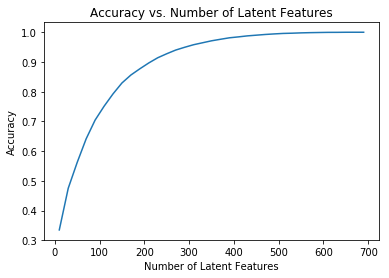

In [270]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [271]:
df_train = df.head(40000)
df_test = df.tail(5993)


def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts
    - all of the test article ids
    
    '''

    user_item_train = df_train.groupby(['user_id', 'article_id'])['exists'].max().unstack()
    user_item_test = df_test.groupby(['user_id', 'article_id'])['exists'].max().unstack()
    
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [272]:
cold_start_user = len(set(user_item_test.index).difference(set(user_item_train.index)))
articles_make_predictions_for = len(set(user_item_test).difference(set(user_item_train.index)))
articles_cold_start_problem = len(set(test_arts).difference(set(user_item_train.columns)))
users_can_make_predictions_in_test = len(set(test_idx).intersection(set(user_item_train.index)))

In [273]:
print(f'We can make predictions for {users_can_make_predictions_in_test} users in the test set.\nThere \
are {cold_start_user} users that we could not make a prediction for because of the cold \
start problem.\nAs for articles, there are {articles_make_predictions_for} we can make predictions \
for in the test set and {articles_cold_start_problem} articles for which we cannot make a prediction \
for due to the cold start problem.')

We can make predictions for 20 users in the test set.
There are 662 users that we could not make a prediction for because of the cold start problem.
As for articles, there are 574 we can make predictions for in the test set and 0 articles for which we cannot make a prediction for due to the cold start problem.


In [274]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c ,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a, # letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test movies are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

Ok, so we are going to run svd on the training set. Then we are going to run it on the subset of 20 users that were in the training and the testing sets. Then we are going to compare the results with the actual preferences of the 20 in the testing set. 

So, the algorythm is run svd on the training set. 

Get the ids of the users that were in the training set and the testing set. 

Get the subset of the users and recombine the u, s, and vt matrices for those 20 users to make predictions for those 20 users. The predictions, `pred`, will be the probabilities of having read or interacted with the articles. It will hopefully be numbers very close to 1 or 0. It will be a matrix with 20 rows and 714 columns. 

Then get the actual values for those 20 users in the test set. Store it in a variable called `actual`. It, too, will be a matrix with 20 rows and 714 columns. 

Subtract the `actual`s from the `pred`s and store it in a matrix called `diff`. 

Then we will sum across the rows and columns of `diff`. This will give us an error for the exercise. 


In [275]:
#split the data into train and test splits and get the identifying indexes for the test set
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [277]:
print(type(test_idx))
print(type(user_item_train))

<class 'pandas.core.indexes.numeric.Int64Index'>
<class 'pandas.core.frame.DataFrame'>


In [280]:
#find the subset of ids that are both in the training set and in the testing set
train_test_ids = list(set(user_item_train.index).intersection(set(user_item_test.index)))

In [281]:
len(train_test_ids)

20

In [287]:
#fill in missing values with 0
user_item_train.fillna(0, inplace=True)

In [288]:
#perform SVD on the training set
u, s, vt = np.linalg.svd(user_item_train, full_matrices=True, compute_uv=True)

In [308]:
print(u.shape)
print(s.shape)
print(vt.shape)

(4487, 4487)
(714,)
(714, 714)


In [289]:
# set the number of latent features to keep
k = 100 

First I am going to try to recombine the matrixes just by limiting the factors to 100. 

In [339]:
np.dot(np.dot(u[:, :k], np.diag(s[:k])), vt[:k, :])

array([[-5.18092178e-03,  3.76118494e-02,  3.21709738e-03, ...,
         6.61068580e-02, -9.93999191e-02,  1.76797550e-02],
       [ 1.69345991e-02,  1.00346639e-02, -2.03664616e-02, ...,
         1.74809304e-02,  6.68644660e-02,  1.20239695e-04],
       [ 2.07553425e-03, -1.61953299e-02,  1.61265277e-02, ...,
         9.65853391e-02,  2.99114979e-01, -1.33636581e-02],
       ...,
       [-5.20859679e-03, -1.63991891e-03,  4.47916021e-03, ...,
         1.54540023e-02, -9.27100438e-03, -1.16277550e-03],
       [-7.00591366e-03, -3.79058411e-04,  9.05646080e-03, ...,
         2.84512638e-02,  1.61868790e-02,  2.21583289e-04],
       [-1.95496494e-02, -1.02380968e-02, -2.32490671e-02, ...,
        -5.75268728e-03,  5.26296592e-02, -8.49288587e-03]])

In [306]:
user_item_train[user_item_train.index.isin(train_test_ids)].shape

(20, 714)

In [333]:
u_train_test = []
for i, j in enumerate(u):
    if i in train_test_ids:
        u_train_test.append(j)

In [334]:
u_train_test_array = np.array(u_train_test)

In [335]:
u_train_test_array[18]

array([-0.00509165, -0.00354647,  0.00196334, ...,  0.00342277,
        0.00317444, -0.00453802])

In [336]:
print(len(u_train_test))
print(len(train_test_ids))


19
20


First I am going to have to get the rows in the test set that are also in the training set. That amounts to 20 users. We found that number with this code: 

In [114]:
articles_make_predictions_for = len(set(user_item_test).difference(set(user_item_train.index)))
articles_make_predictions_for

574

That makes no sense. It should be 20. lets see what we have in each of the variables. 

In [119]:
print(user_item_train.index)
print(user_item_test.index)
print(len(user_item_train.index))
print(len(user_item_test.index))

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            4478, 4479, 4480, 4481, 4482, 4483, 4484, 4485, 4486, 4487],
           dtype='int64', name='user_id', length=4487)
Int64Index([2917, 3024, 3093, 3193, 3527, 3532, 3684, 3740, 3777, 3801,
            ...
            5140, 5141, 5142, 5143, 5144, 5145, 5146, 5147, 5148, 5149],
           dtype='int64', name='user_id', length=682)
4487
682


In [122]:
train_test_ids = []
for i in user_item_train.index:
    if i in user_item_test.index:
        train_test_ids.append(i)
print(len(train_test_ids))

20


In [127]:
train_test_ids_set = list(set(user_item_train.index).intersection(set(user_item_test.index)))
print(len(train_test_ids_set)) 
print(len(train_test_ids))

20
20


In [133]:
print(type(train_test_ids_set))
print(type(train_test_ids))

<class 'list'>
<class 'list'>


In [149]:
user_item_train.fillna(0, inplace=True)
u, s, vt = np.linalg.svd(user_item_train, full_matrices=True, compute_uv=True)

In [197]:
user_item_test_in_train = user_item_test.loc[user_item_test.index.isin(train_test_ids)]

In [202]:
user_item_test_in_train = user_item_test_in_train.fillna(0)

In [252]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

k = 10
s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]

In [253]:
vt_new.shape

(10, 714)

In [254]:
user_item_est = np.around(np.dot(np.dot(u_new[user_item_train.index.isin(test_idx)], s_new), vt_new))

In [255]:
diff = np.subtract(user_item_train[user_item_train.index.isin(train_test_ids)].fillna(0), user_item_est)
diff

article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3193,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3532,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3777,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [258]:
err = np.sum(np.sum(np.abs(diffs**2)))

In [259]:
err

0.0

In [223]:
# for k in num_latent_feats:
#     # restructure with k latent features
#     s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
#     # take dot product
#     user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
#     # compute error for each prediction to actual value
#     diffs = np.subtract(user_item_matrix, user_item_est)
    
#     # total errors and keep track of them
#     err = np.sum(np.sum(np.abs(diffs)))
#     sum_errs.append(err)
    
    
# plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
# plt.xlabel('Number of Latent Features');
# plt.ylabel('Accuracy');
# plt.title('Accuracy vs. Number of Latent Features');

ME: Now it is important to note what a prediction is in this situation. The prediction is whether or not the users will have interacted with the article at all. And it should be a probability of interaction. This means that instead of zeros we will often have very small numbers but not zeros. 

In [94]:
user_item_train = user_item_train.fillna(0)

In [95]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train, full_matrices=True, compute_uv=True) # fit svd similar to above then use the cells below



In [96]:
mse = []
for k in range(1,701,10):
    s_new, u_new, vt_new = np.diag(s_train[:k]), u_train[:, :k], vt_train[:k, :]
    user_item_est = pd.DataFrame(np.around(np.dot(np.dot(u_new, s_new), vt_new)))
    user_item_est_test = []
    sse = 0
    for i in user_item_est.index:
        if i in test_idx:
            sse += ((user_item_est[user_item_est.index==i].values - user_item_train[user_item_est.index==i].values)**2).sum(axis=1)
    mse.append(np.sqrt(sse))

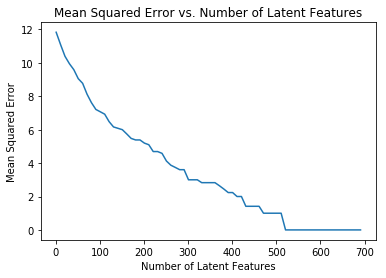

In [97]:
num_latent_feats = range(1,701,10)
plt.plot(num_latent_feats, mse);
plt.xlabel('Number of Latent Features');
plt.ylabel('Mean Squared Error');
plt.title('Mean Squared Error vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 


The mean squared error goes down as the number of latent features goes up, finally reaching zero shortly after passing 500. This is not surprising as there are only 714 articles in the data set so by the time we get to 500 we are using using all the information in the data. We are most likely fitting to the idiosycracies in the data rather than to the real, underlying causally relavant characteristics of the data. Therefore, for making recommendations, it would probaby be best to stop at some point well before the 500s. Improvement in the MSE has largely leveled off in the 400s so I would probably limit the number of latent features to something around 400 for making article recommendations. 

In [601]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])

0